# E-commerce — Выявление профилей потребления

###### Дополнительные материалы:
- презентация https://docs.google.com/presentation/d/1_r1bdpB-9oEe4PHbSGohHSLf2PF1PQaZFIY6OFcnv-M/edit?usp=sharing
- дашборд https://public.tableau.com/profile/pavel7546#!/vizhome/E-commerce2_16119189816050/Dashboard1

### План выполнения проекта:
<br>[Шаг 1. Предоброботка данных](#step1)
<br>[Шаг 2. Исследовательский анализ данных](#step2)
<br>[Шаг 3. Сегментация пользователей на основе истории их покупок](#step3)
<br>[Шаг 4. Проверка гипотез](#step4)
<br>[ВЫВОДЫ](#step5)

### Шаг 1. Предоброботка данных<a id='step1'></a>

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters

Загрузим данные и подготовим их к анализу

In [2]:
pd.options.display.max_colwidth=150
data= pd.read_csv('/datasets/ecommerce_dataset.csv')
display(data.head(3))
data.info()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Пропусков в данных нет, приведем данные к верным типами и удалим возможные дубликаты

In [3]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')
data['product'] = data['product'].str.lower()
data.duplicated().sum()

0

Дата приведена к читаемому виду, дубликаты не однаружены

Проверим наличие одинаковых заказов, без учета даты

In [4]:
data[['customer_id','order_id','product','quantity', 'price']].duplicated().sum()

1864

Видим, что таких заказов достаточно много, потому как один заказ должен соответствовать одной дате, то скорее всего это ошибки, и такие данные лучше удалить.

In [5]:
data['duplicat'] = data[['customer_id','order_id','product','quantity', 'price']].duplicated()
data = data.query('duplicat == False')

Добавим столбец с суммой заказа по каждой позиции, удалим более не нужный столбец, о наличии дубликатов.

In [6]:
data['summa'] = data['quantity'] * data['price']
del data['duplicat']

display(data.head(3))
data.info()

,date,customer_id,order_id,product,quantity,price,summa
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4873 entries, 0 to 6735
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4873 non-null   datetime64[ns]
 1   customer_id  4873 non-null   object        
 2   order_id     4873 non-null   int64         
 3   product      4873 non-null   object        
 4   quantity     4873 non-null   int64         
 5   price        4873 non-null   float64       
 6   summa        4873 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 304.6+ KB


### Шаг 2. Исследовательский анализ данных<a id='step2'></a>

Поделим товары на 2 группы: растения и товары для дома, добавим столбец с пренадлежностью к группе 

In [7]:
group = []
for product in data['product']:
    pattern = re.compile('d.[0-9]+ | d[0-9]+ | p.(\d{1,2}) | d.[0-9] | d..(\d{1,2}) | (\d{1,2},)\d{1,2}.г')
    result = pattern.findall(product)
    if result != [] and 'муляж' not in product:
        g = 'растения'
    elif 'черенок' in product:
        g = 'растения'
    elif 'пеларгон' in product:
        g = 'растения'
    elif 'настурция' in product:
        g = 'растения'    
    elif 'диам.' in product:
        g = 'растения'
    elif 'сорт ' in product:
        g = 'растения' 
    elif 'горш' in product:
        g = 'растения'
    elif 'крым' in product:
        g = 'растения'     
    elif 'арбуз' in product:
        g = 'растения'
    elif 'дыня' in product:
        g = 'растения'
    elif 'спел' in product:
        g = 'растения'
    elif 'растение' in product:
        g = 'растения'
    elif 'рассада' in product:
        g = 'растения'
    elif 'обыкновен' in product:
        g = 'растения'    
    elif ' лист' in product:
        g = 'растения'    
    elif 'объем ' in product:
        g = 'растения'
    elif 'в кассете' in product:
        g = 'растения'    
    else:
        g = 'товары для дома'   
    group.append(g)
data['group'] = group
display(data.head(3))
data['group'].value_counts()
#data.to_csv('C:\\final project\\new_data')

,date,customer_id,order_id,product,quantity,price,summa,group
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,194.0,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,растения


растения           2501
товары для дома    2372
Name: group, dtype: int64

Выделим товары из разных группы в 2 разные таблицы:

In [8]:
data_r = data.query('group == "растения"')
data_t = data.query('group == "товары для дома"')

Посмотрим, данными за какой срок, мы распологаем 

In [9]:
print('Дата первой покупки', data['date'].min())
print('Дата последней покупки', data['date'].max())

Дата первой покупки 2018-10-01 00:00:00
Дата последней покупки 2019-10-31 14:00:00


Итого у нас есть данные о покупках за полных 13 месяцев

Посмотрим на количество продаж по месяцам

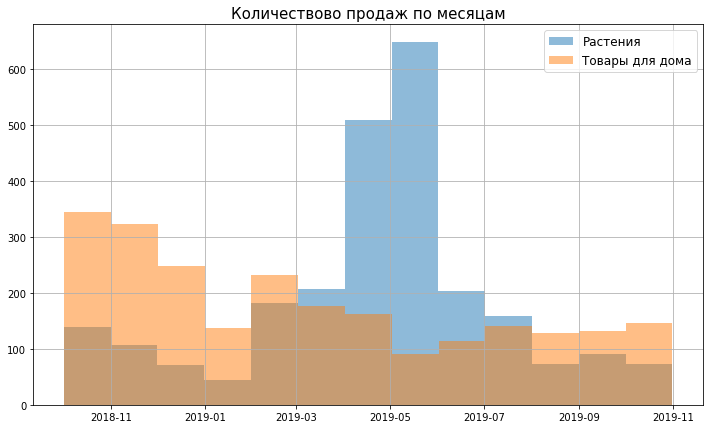

In [10]:
register_matplotlib_converters()
data.groupby('group')['date'].hist(figsize=(12,7), bins=13, alpha=0.5)
plt.title('Количествово продаж по месяцам', fontsize = 15)
plt.legend(['Растения', 'Товары для дома'], fontsize = 12)
plt.show();

Из графика можно сделать следующие выводы:
- товары для дома покупали чуть активнее в конце 2018 года, в 2019 году спрос немного упал, но держался достаточно равномерным на протяжении всего 2019 года;
- спрос на живые растения начинает увеличиваться с февраля 2019 и растет до пика в июне месяце, после чего идет резкое падение продаж. Последние 3 месяца анализируемого периода спрос на живые растения остается стабильно низким.

In [11]:
print('Минимальная цена еденицы товара', data['price'].min())
print('Максимальная цена еденицы товара', data['price'].max())

Минимальная цена еденицы товара 9.0
Максимальная цена еденицы товара 14917.0


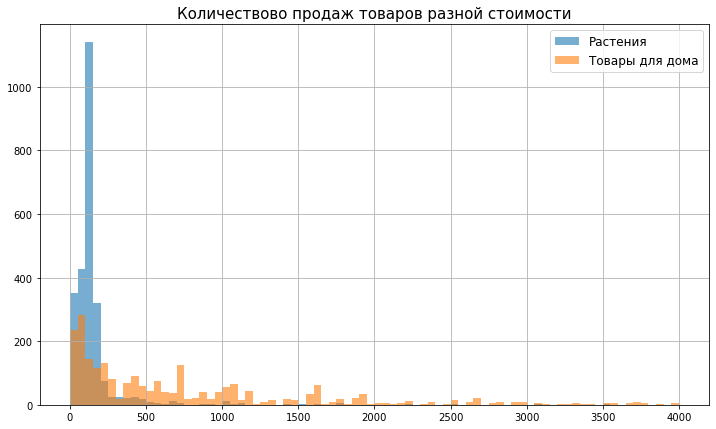

In [12]:
data.groupby('group')['price'].hist(figsize=(12,7), bins=80, range=(1,4000), alpha=0.6)
plt.title('Количествово продаж товаров разной стоимости', fontsize = 15)
plt.legend(['Растения', 'Товары для дома'], fontsize = 12)
plt.show();

<br>Из гистограммы видно, что почти все товары в категории "растения" продавались по цене до 250 рублей. При этом большинство из них продавалось по цене 100 - 150 рублей.

<br>Товары в из категории "товары для дома" более разнообразны, и количество проданных товаров постепенно уменьшается в след за увеличением цены.

Составим таблицу с количеством товаров в заказе и стоимостью чека:

In [13]:
orders = pd.DataFrame(data.groupby(['order_id']).agg({'summa': 'sum', 'quantity': 'sum'}))
display(orders.head(3))
orders.shape

,summa,quantity
order_id,,
12624,375.0,2
13547,684.0,3
14480,359.0,3


(2784, 2)

Составим такие же таблицы для товаров из разных групп:
- для растений

In [14]:
orders_r = pd.DataFrame(data_r.groupby(['order_id']).agg({'summa': 'sum', 'quantity': 'sum'}))
display(orders_r.head(3))
orders_r.shape

,summa,quantity
order_id,,
12624,375.0,2
13547,684.0,3
14480,359.0,3


(769, 2)

- для товаров для дома

In [15]:
orders_t = pd.DataFrame(data_t.groupby('order_id').agg({'summa': 'sum', 'quantity': 'sum'}))
display(orders_t.head(3))
orders_t.shape

,summa,quantity
order_id,,
14512,47.0,2
14595,379.0,18
14597,89.0,1


(2034, 2)

По количеству заказов видно, что пользователи крайне редко заказывают товары из разных групп в одном заказе.

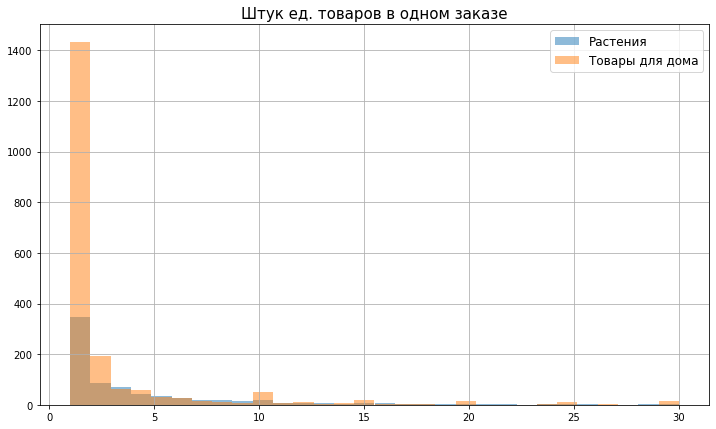

In [16]:
orders_r['quantity'].hist(figsize=(12,7), bins=30, range=(1,30), alpha=0.5)
orders_t['quantity'].hist(figsize=(12,7), bins=30, range=(1,30), alpha=0.5)
plt.title('Штук ед. товаров в одном заказе', fontsize = 15)
plt.legend(['Растения', 'Товары для дома'], fontsize = 12)
plt.show();

Видим, что вподавляющем большинстве заказов присутствует лишь один товар, особенно ярко это выражено в группе товаров для дома.

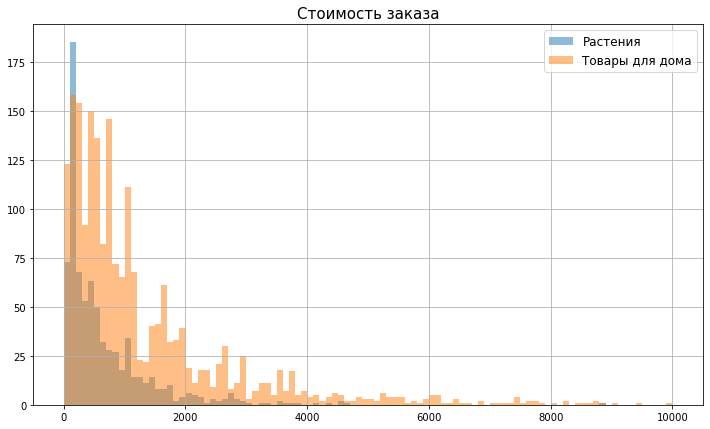

In [17]:
orders_r['summa'].hist(figsize=(12,7), range=(1,10000), bins=100, alpha=0.5)
orders_t['summa'].hist(figsize=(12,7), range=(1,10000), bins=100, alpha=0.5)
plt.title('Стоимость заказа', fontsize = 15)
plt.legend(['Растения', 'Товары для дома'], fontsize = 12)
plt.show();

Видим, что в целом товаров для дома продается больше, но распределение стоимости заказов различается в обоих группах не сильно: чем дороже заказ, тем реже он случается.

### Шаг 3. Сегментация пользователей на основе истории их покупок:<a id='step3'></a>

##### Сегментацияна основе купленных товаров

Посмотрим на данные в разрезе пользователей

In [18]:
customers = pd.DataFrame(data.groupby(['customer_id']).agg({'summa': 'sum', 'quantity': 'sum', 'order_id': 'count'}))
display(customers.sort_values('order_id', ascending=False).head(3))
customers.shape

,summa,quantity,order_id
customer_id,,,
c971fb21-d54c-4134-938f-16b62ee86d3b,159508.0,334,143
d3b9ffea-d143-4747-8d59-74ab843d1ad6,2922.0,51,51
4d93d3f6-8b24-403b-a74b-f5173e40d7db,57278.0,309,45


(2451, 3)

Для клиентов, покупающих растения

In [19]:
customers_r = pd.DataFrame(data_r.groupby(['customer_id']).agg({'summa': 'sum', 'quantity': 'sum', 'order_id': 'count'}))
display(customers_r.sort_values('order_id', ascending=False).head(3))
customers_r.shape

,summa,quantity,order_id
customer_id,,,
d3b9ffea-d143-4747-8d59-74ab843d1ad6,2922.0,51,51
760aa067-90c3-4794-b7a9-a8831197388b,4558.0,37,36
2a0acc09-e343-4f92-b5c0-f598ef2b07d4,2280.0,60,31


(674, 3)

Для клиентов, покупающих товары для дома

In [20]:
customers_t = pd.DataFrame(data_t.groupby(['customer_id']).agg({'summa': 'sum', 'quantity': 'sum', 'order_id': 'count'}))
display(customers_t.sort_values('order_id', ascending=False).head(3))
customers_t.shape

,summa,quantity,order_id
customer_id,,,
c971fb21-d54c-4134-938f-16b62ee86d3b,145834.0,295,113
4d93d3f6-8b24-403b-a74b-f5173e40d7db,55492.0,296,42
9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,22056.0,47,21


(1805, 3)

###### Посмотрим, есть ли покупатели, совершавшие покупки в обоих категориях и выделим их в отдельную группу

Возьмем данные о пользователях, которые состоят в обеих группах и объеденим в отдельную таблицу. Удалим данные из групп, где пользователи совершали только покупки из определенной группы товаров.

In [21]:
dup_customers_r = customers_r.loc[customers_r.index.isin(customers_t.index)]
dup_customers_t = customers_t.loc[customers_t.index.isin(customers_r.index)]
customers_r = customers_r.loc[~customers_r.index.isin(customers_t.index)]
customers_t = customers_t.loc[~customers_t.index.isin(customers_r.index)]
dup_customers = dup_customers_r.merge(dup_customers_t, left_index=True, right_index=True)

Объеденим дублирующиеся поля и не нужные данные удалим.

In [22]:

dup_customers['summa'] = dup_customers['summa_x'] + dup_customers['summa_y']
dup_customers['quantity'] = dup_customers['quantity_x'] + dup_customers['quantity_y']
dup_customers['order_id'] = dup_customers['order_id_x'] + dup_customers['order_id_y']

dup_customers.drop(['summa_x', 'summa_y', 'quantity_x', 'quantity_y', 'order_id_x', 'order_id_y'], axis=1, inplace=True)
display(len(dup_customers))

28

Видим, что у нас есть, только 28 пользователей, делавших покупки из разных категорий, это около 1% от всех пользователей, так что, можно считать, что все пользователи поделены на 2 группы: покующие товары из категории "растения" и "товары для дома"

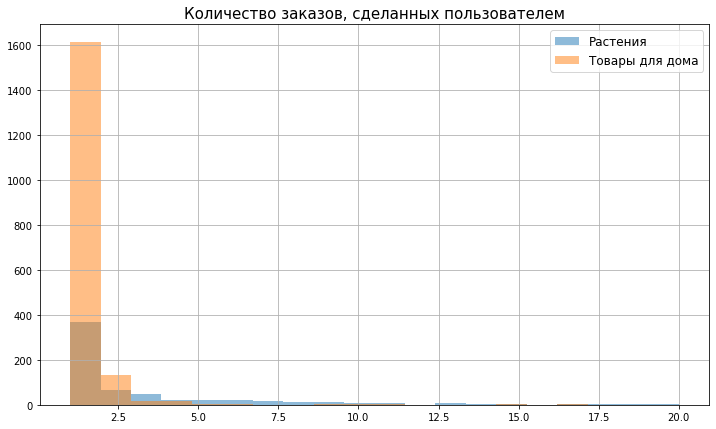

In [23]:
customers_r['order_id'].hist(figsize=(12,7), bins=20, range=(1,20), alpha=0.5)
customers_t['order_id'].hist(figsize=(12,7), bins=20, range=(1,20), alpha=0.5)
plt.title('Количество заказов, сделанных пользователем', fontsize = 15)
plt.legend(['Растения', 'Товары для дома'], fontsize = 12)
plt.show();

Абсолютное большинство пользователей, совершило только 1 заказ за последние 13 месяцев. Небольшая часть пользователей совершила от 2 до 9 заказов. Больше 9 заказов за отчетный период совершили еденицы пользователей.

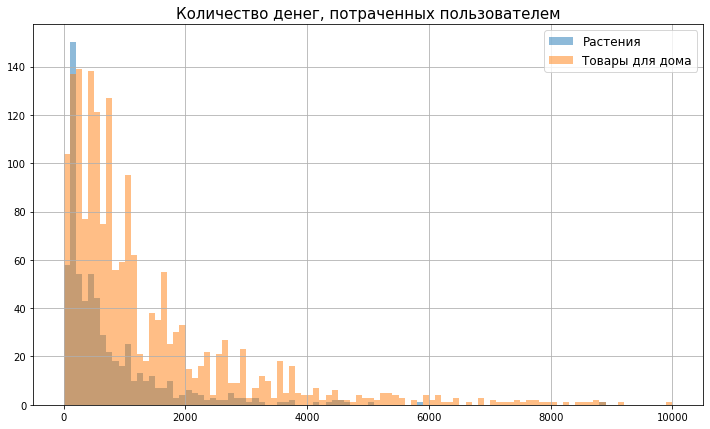

In [24]:
customers_r['summa'].hist(figsize=(12,7), bins=100, range=(1,10000), alpha=0.5)
customers_t['summa'].hist(figsize=(12,7), bins=100, range=(1,10000), alpha=0.5)
plt.title('Количество денег, потраченных пользователем', fontsize = 15)
plt.legend(['Растения', 'Товары для дома'], fontsize = 12)
plt.show();

Эта гистограмма очень напоминает гистограмму стоимости заказов, т.к. большинство пользователей совершили только по одному заказу, соответственно сумма потраченных ими денег равна стоимости заказа.  

##### Сегментация пользователей на основе даты первой покупки:

In [25]:

first_activity_date = data.groupby('customer_id')['date'].min()
first_activity_date.name = 'first_activity_date'
data = data.merge(first_activity_date, on='customer_id', how='left')


In [26]:
data['first_order_month'] = data['first_activity_date'].astype('datetime64[M]')
data['order_month'] = data['date'].astype('datetime64[M]')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4873 entries, 0 to 4872
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 4873 non-null   datetime64[ns]
 1   customer_id          4873 non-null   object        
 2   order_id             4873 non-null   int64         
 3   product              4873 non-null   object        
 4   quantity             4873 non-null   int64         
 5   price                4873 non-null   float64       
 6   summa                4873 non-null   float64       
 7   group                4873 non-null   object        
 8   first_activity_date  4873 non-null   datetime64[ns]
 9   first_order_month    4873 non-null   datetime64[ns]
 10  order_month          4873 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(2), object(3)
memory usage: 456.8+ KB


Посчитаем количество покупателей в каждой кагорте:

In [27]:
cohort_sizes = data.groupby('first_order_month').agg({'customer_id': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа, посчитаем выручку с каждой кагорты в каждый месяц и добавим общее число участников кагорты.

In [28]:
cohorts = data.groupby(['first_order_month','order_month']).agg({'summa': 'sum'}).reset_index()
cohorts = cohorts.merge(cohort_sizes, on='first_order_month')
display(cohorts.head(3)) 

,first_order_month,order_month,summa,n_buyers
0,2018-10-01,2018-10-01,351910.0,181
1,2018-10-01,2018-11-01,24981.0,181
2,2018-10-01,2018-12-01,43993.0,181


Для расчета показателя LTV нужно знать валовую прибыль. К сожалению, у нас нет данных о маржинальности, так что будем считать не совсем LTV, а значения, показывающие, сколько выручки принесли покупатели каждой кагорты. 

Расчитаем возраст каждой кагорты для каждого месяца:

In [29]:
cohorts['age'] = (cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')
cohorts['first_order_month'] = cohorts['first_order_month'].dt.strftime('%Y-%m')
cohorts['age'] = cohorts['age'].round().astype('int')
display(cohorts.head()) 

,first_order_month,order_month,summa,n_buyers,age
0,2018-10,2018-10-01,351910.0,181,0
1,2018-10,2018-11-01,24981.0,181,1
2,2018-10,2018-12-01,43993.0,181,2
3,2018-10,2019-01-01,9449.0,181,3
4,2018-10,2019-02-01,44806.0,181,4


И так, посмотри сколько выручки принёс один покупатель из каждой кагорты:

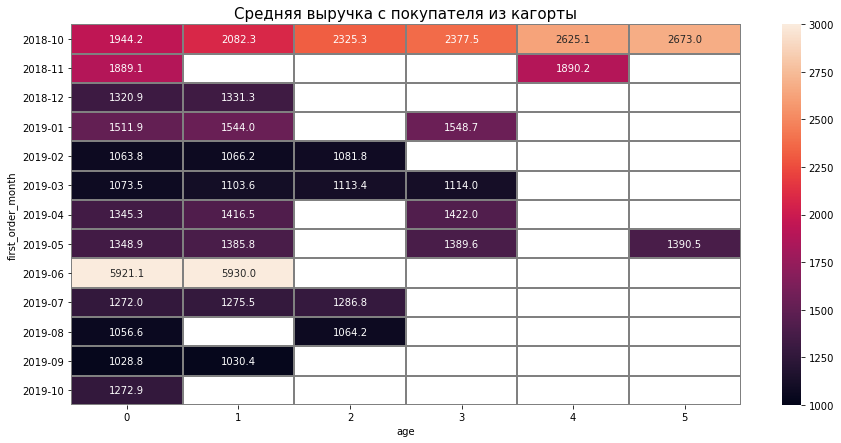

In [30]:
cohorts['revenue'] = cohorts['summa'] / cohorts['n_buyers'] 
LTV = cohorts.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='revenue', 
        aggfunc='mean').cumsum(axis=1).round(2)   
LTV.fillna('') 
plt.figure(figsize=(15, 7))
plt.title('Средняя выручка с покупателя из кагорты', fontsize=15)
sns.heatmap(LTV, annot=True, fmt='.1f', linewidths=1, vmin=1000, vmax=3000, linecolor='gray');

Кагортный анализ показал, что главная проблема нашего магазина - возврат клиентов. Тольки покупатели из первой кагорты приносили выручку первые пол года после совершения покупки. Клиенты из остальных кагорт совершали покупки в первый месяц (чаще всего только 1 заказ) и больше не приносили никакой выручки.

### Шаг 4. Проверка гипотез<a id='step4'></a>

##### Сравним средний чек в заказах из разных групп товаров

Выдвенем нулевую гипотезу о равенстве чеков групп, "растения" и "товары для дома" и проверим её:

In [31]:
def ttest(x, y):
    alpha = .05 
    results = st.ttest_ind(
        x, 
        y, equal_var = False)

    print('p-значение:', results.pvalue)

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
ttest(orders_r['summa'], orders_t['summa'])        

p-значение: 0.8694957803728596
Не получилось отвергнуть нулевую гипотезу


Таким образом, нельзя утверждать, что среднии чеки покупок товаров из этих групп отличаются на статистически значимую величину.

##### Сравним средние суммы, оставленные покупателями товаров разных групп

Выдвенем нулевую гипотезу: покупатели товаров из разных групп потратили одинаковое количество денег на покупки

In [32]:
ttest(customers_r['summa'],customers_t['summa'])

p-значение: 0.8556410004327429
Не получилось отвергнуть нулевую гипотезу


Судя по этому тесту: покупатели товаров из обеих групп одинаково ценны для нашего магазина.

##### Проверим эти гипотезы еще раз, исключив выбросы:

In [33]:
print(np.percentile(orders_r['summa'], [95, 99]))
print(np.percentile(orders_t['summa'], [95, 99]))
print(orders_r['summa'].mean())
print(orders_t['summa'].mean())

[2269.6 4384.6]
[4574.   8512.71]
1582.6371911573472
1438.1052114060963


Чтоб исключить минимум 1 % выбросов, заказы стоимость выше 4385 уберем из данных

In [34]:
orders_r_new = orders_r[orders_r['summa'] < 4385]
orders_t_new = orders_t[orders_t['summa'] < 4385]
print(orders_r_new['summa'].mean())
print(orders_t_new['summa'].mean())

638.7674113009199
1046.33714880333


Проведем тест по очищенным данным

In [35]:
ttest(orders_r_new['summa'], orders_t_new['summa'])

p-значение: 1.3981804407635286e-33
Отвергаем нулевую гипотезу


Убрав выбросы, можно утверждать, что с большой долей вероятности, средняя стоимость заказа из категории "товары для дома" выше, чем из категории "растения".

Проделаем то же с затратами пользователей

In [36]:
print(np.percentile(customers_r['summa'], [95, 99]))
print(np.percentile(customers_t['summa'], [95, 99]))
print(customers_r['summa'].mean())
print(customers_t['summa'].mean())

[2692.5 4640.6]
[4865.4  9884.32]
1811.6934984520124
1620.5573407202216


Исключим минимум 1% выбросов, и посмотрим как изменится среднии и результаты теста.

In [37]:
customers_r_new = customers_r[customers_r['summa'] < 4640]
customers_t_new = customers_t[customers_t['summa'] < 4640]
print(customers_r_new['summa'].mean())
print(customers_t_new['summa'].mean())

702.7527386541472
1083.4625730994153


In [38]:
ttest(customers_r_new['summa'],customers_t_new['summa'])

p-значение: 2.4884147865063023e-21
Отвергаем нулевую гипотезу


Без выбросов, становится очевидно, что пользователи, покупавшие товары из группы "товары для дома" приносят больше выручки магазину.

### ВЫВОДЫ:<a id='step5'></a>
- товары из разных групп продаются в течении года по разному: товары для дома продаются более-менее равномерно в течении всего периода, а растения покупают гораздо активнее в мае и июне;
- стоимоть одного проданного товара из группы "растения" редко превышает 200 рублей, цена товаров для дома гораздо разнообразнее, из этой категории часто продают более дорогие товары;
- большинство покупателей покупает только один товар в заказе, это характерно для обоих групп, но больше выражено в группе товаров для дома;
- к сожалению большинство наших клиентов делает только 1 покупку и больше не возвращаются;
- средний чек покупки и количество денег, потраченных клиентом заметно выше в категории товаров для дома.


##### Рекомендации маркетологам:
- необходимо мотивировать клиента покупать больше одного продукта в заказе;
- нужно найти причину, почему пользователи редко возвращаются, и увеличить повторные заказы клиентов;
- лучше больше сосредоточится на продвижении товаров для дома, так как товары из этой группы продаются в течении всего года и приносят больше выручки. 

<div class="alert alert-success"> 
    
Отлично! Коротко и ёмко, поставленные цели достигнуты, выводы и рекомендации сделаны. Презентация очень симпатичная.  
    
Разделение товаров на категории получилось очень компактным, но при этом работающим: у групп ярко выраженная сезонность, редко пересекаются в покупках. Класс!
    
Вопрос только к дашборду: что-то у меня цифры не бьются. И там кол-во пользователей, похоже, всегда совпадает с количеством заказов.  
Проверял по табличке ниже:

</div>

In [39]:
data['day'] = data['date'].dt.normalize()

example = data.groupby('day').agg({'customer_id': 'nunique', 'order_id': 'nunique'})
example['diff'] = np.abs(example['customer_id'] - example['order_id'])

example.sort_values('diff', ascending=False).head(10)

,customer_id,order_id,diff
day,,,
2018-10-08,9,14,5
2019-02-11,11,15,4
2019-04-19,2,6,4
2018-12-10,13,17,4
2018-10-09,9,13,4
2018-12-24,14,18,4
2019-10-16,15,18,3
2018-12-17,14,17,3
2019-03-01,15,18,3
